## 7.2 Experiment Region Proposal

⚠️⚠️⚠️ *Please open this notebook in Google Colab* by click below link ⚠️⚠️⚠️<br><br>
<a href="https://colab.research.google.com/github/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/blob/main/Pertemuan%207/7.2%20experiment_region_proposal.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><br><br><br>
- Click `Connect` button in top right Google Colab notebook,<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/blob/main/Pertemuan%207/resource/cl-connect-gpu.png?raw=1" width="250px">
- If connecting process completed, it will turn to something look like this<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/blob/main/Pertemuan%207/resource/cl-connect-gpu-success.png?raw=1" width="250px">

_________
<br><br><br><br>
#### 7.2.1 <font color="orange">Selective Search</font>
- Simple implementation Selective Search using OpenCV to perform segmentation based on color similarity
- Then producing proposed bounding box as a result countour of segmented image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

- Load the image

In [2]:
# Download an example image from repo
import urllib
url, filename = ("https://github.com/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/raw/main/Pertemuan%207/astronaut.jpg", "astronaut.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

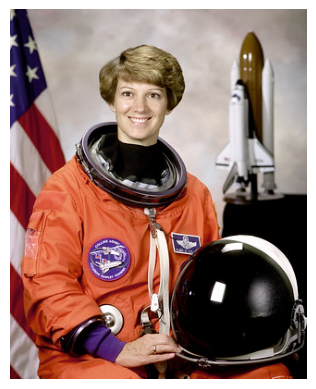

In [3]:
image = cv2.imread("astronaut.jpg")

# show image using matplot lib
def imshow(image, isBGR=True):
    if isBGR :
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

imshow(image)

- Define function for color quantization using <font color="orange">K-means clustering</font>,
    - Choose Number of <font color="orange">Clusters</font> ($k$),
        - For example, if you have a bunch of points and want to split them into 3 groups, you set $k=3$.
    - Initialize <font color="orange">Centroids</font>,
        - Randomly place $k$ points (called <font color="orange">centroids</font>) in the space where your data points lie.
    - Update Centroids,
        - For each cluster, calculate the <font color="orange">average</font> of all points assigned to that cluster.
        - This <font color="orange">new average</font> becomes the updated <font color="orange">centroid</font> for the cluster.
    - <font color="orange">Repeat</font> Until Stable,
        - Steps 3 and 4 are repeated until the centroids <font color="orange">no longer change</font> much (or at all) between iterations.
        - This means each data point has found its "best" cluster.<br><br>
        <img src="https://github.com/Muhammad-Yunus/Belajar-OpenCV-ObjectDetection/blob/main/Pertemuan%207/resource/K-Means.gif?raw=1" width="900px"><br>


- Implement K-Means Clustering using OpenCV `cv2.kmeans()`,
    ```
    retval, bestLabels, centers = cv2.kmeans(data, K, bestLabels, criteria, attempts, flags)
    ```
    - where :
        - `K` Number of clusters to split the set by.
        - `bestLabels` Input/output integer array that stores the cluster indices for every sample.
        - `criteria` The algorithm termination criteria, can be the maximum number of iterations and/or the desired accuracy.
        - `attempts` to specify the number of times the algorithm is executed using different initial labellings.
        - `flags` to set random initial centers in each attempt. can take values of,
            - cv2.KMEANS_RANDOM_CENTERS     = 0,
            - cv2.KMEANS_PP_CENTERS         = 2,
            - cv2.KMEANS_USE_INITIAL_LABELS = 1,


In [4]:
def color_quantization(image, k=5):
    # Convert to Lab color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Reshape the image data to a 2D array of pixels
    pixel_values = image_lab.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply KMeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 15, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    quantized_image = centers[labels.flatten()]

    # Reshape back to the original image dimensions
    quantized_image = quantized_image.reshape(image.shape)
    return cv2.cvtColor(quantized_image, cv2.COLOR_Lab2BGR)

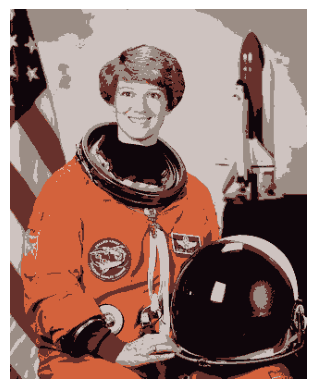

In [5]:
# generate segmented image using k=5
segmented_image = color_quantization(image, k=5)

# show segmented image
imshow(segmented_image)

- Define function to extract Bounding Box from segmented image
    - Convert `segmented_image` to binary image (black & white) using Otsu Thresholding (`cv2.THRESH_OTSU`),
    - Find contour on binary image using `cv2.findContours()`,
    - Find Bouding Box on detecting contour using `cv2.boundingRect()`
    - Filter box size $w*h$ >= $min size$

In [6]:
def get_bounding_boxes(segmented_image, min_size=200):
    # Convert to grayscale and apply binary thresholding
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create bounding boxes for contours larger than min_size
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h >= min_size:
            boxes.append((x, y, w, h))
    return boxes

In [7]:
boxes = get_bounding_boxes(segmented_image, min_size=500)

print(boxes)

[(243, 386, 57, 14), (212, 370, 95, 14), (239, 346, 72, 33), (0, 329, 54, 71), (133, 320, 30, 37), (90, 283, 60, 41), (67, 276, 16, 32), (96, 256, 37, 40), (83, 246, 42, 34), (129, 245, 17, 46), (69, 121, 124, 113), (95, 67, 24, 38), (142, 52, 48, 60), (244, 24, 32, 126), (0, 0, 321, 400)]


- Draw bounding box on original image using `cv2.rectangle`

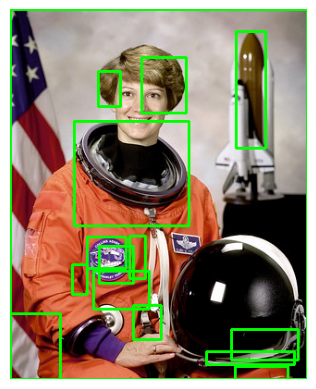

In [8]:
# define maximun number of box to draw
MAX_BOX = 100

# draw box in original image
image_with_boxes = image.copy()
for (x, y, w, h) in boxes[:MAX_BOX]:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# show image with bounding box
imshow(image_with_boxes)

_______
<br><br><br><br>
### 7.2.2 <font color="orange">RPN</font> (Region Proposal Network)
- <font color="orange">Anchor Generation</font> : Define anchor boxes of multiple scales and aspect ratios for each position in a feature map.
- <font color="orange">RPN Network Layers</font> : The RPN typically has a <font color="orange">3x3 convolutional layer</font> to scan over the feature map and two output branches:
    - A classification branch (object vs. background) using <font color="orange">1x1 convolutional layer</font>.
    - A regression branch (bounding box refinements) using <font color="orange">1x1 convolutional layer</font>.
- <font color="orange">Loss Functions</font> : Compute classification and regression loss to train the network.<br>
        <img src="resource/RPN.png" width="700px"><br>

- RPN Implementation in PyTorch

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [72]:
class SimpleRPNHead(nn.Module):
    def __init__(self, in_channels=512, num_anchors=9):
        super(SimpleRPNHead, self).__init__()

        # 3x3 Conv layer for sliding window over the feature map
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)

        # Classification layer: predict if each anchor is an object or not
        # Output 2 scores per anchor: object or background
        self.cls_score = nn.Conv2d(512, num_anchors * 2, kernel_size=1)

        # Regression layer: predict 4 adjustments for each anchor's bbox (dx, dy, dw, dh)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for layer in [self.conv, self.cls_score, self.bbox_pred]:
            # initializes the weights of each layer with a normal (Gaussian) distribution
            # with a mean of 0 and a standard deviation of 0.01
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        # Shared convolutional layer
        x = F.relu(self.conv(x))

        # Classification score for each anchor (object vs. background)
        cls_score = self.cls_score(x)

        # Bounding box refinement for each anchor
        bbox_pred = self.bbox_pred(x)

        # Reshape for output
        # cls_score: [batch, num_anchors * 2, H, W] -> [batch, H * W * num_anchors, 2]
        cls_score = cls_score.permute(0, 2, 3, 1).contiguous()
        cls_score = cls_score.view(cls_score.shape[0], -1, 2)

        # bbox_pred: [batch, num_anchors * 4, H, W] -> [batch, H * W * num_anchors, 4]
        bbox_pred = bbox_pred.permute(0, 2, 3, 1).contiguous()
        bbox_pred = bbox_pred.view(bbox_pred.shape[0], -1, 4)

        return cls_score, bbox_pred

- Load pretrained ResNet-34 from torch.hub

In [ ]:
# Load pretrained ResNet-34 from torch hub
backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

# Remove the fully connected layers, keep convolutional layers only
backbone = nn.Sequential(*list(backbone.children())[:-2])  # This keeps layers up to the last Conv layer
backbone.eval()  # Set backbone to evaluation mode

- Load Image Sample

In [13]:
# Load an example image and preprocess it
image_path = 'astronaut.jpg'  # Replace with your image path
image = cv2.imread(image_path)
H, W = 224, 224  # Resize image to this size
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (W, H))  # Resize to a suitable input size for ResNet

# Convert image to tensor and normalize as required by ResNet
input_tensor = torch.tensor(image).float().permute(2, 0, 1).unsqueeze(0)
input_tensor = input_tensor / 255.0
input_tensor = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)(input_tensor)

- Forward pass image tensor to CNN Backbone (Resnet-34)

In [14]:
# Generate feature map using ResNet-34
with torch.no_grad():  # No need to compute gradients here
    feature_map = backbone(input_tensor)

- Initialize RPN

In [73]:
# Initialize RPN with input channels matching the ResNet output (512 channels in ResNet-34)
rpn_head = SimpleRPNHead(in_channels=512, num_anchors=9)

- Forward pass output feature map from backbone network to RPN

In [16]:
# Run the feature map through RPN to get region proposals
cls_scores, bbox_preds = rpn_head(feature_map)

print(f"Feature map shape: {feature_map.shape}")
print(f"Class scores shape: {cls_scores.shape}")
print(f"Bbox predictions shape: {bbox_preds.shape}")

Feature map shape: torch.Size([1, 512, 7, 7])
Class scores shape: torch.Size([1, 441, 2])
Bbox predictions shape: torch.Size([1, 441, 4])


- Create Achor box

In [74]:
class SimpleAnchorGenerator:
    def __init__(self, sizes=[32, 64, 128], aspect_ratios=[0.5, 1.0, 2.0]):
        self.sizes = sizes
        self.aspect_ratios = aspect_ratios

    def generate_anchors(self, grid_size, stride):
        anchors = []
        for size in self.sizes:
            for aspect_ratio in self.aspect_ratios:
                # Compute anchor dimensions
                anchor_height = size / np.sqrt(aspect_ratio)
                anchor_width = size * np.sqrt(aspect_ratio)

                # Generate anchors across the grid
                for y in range(grid_size[0]):
                    for x in range(grid_size[1]):
                        # Convert grid cell coordinates to center coordinates in image space
                        center_x = (x + 0.5) * stride
                        center_y = (y + 0.5) * stride

                        # Calculate the (x_min, y_min, x_max, y_max) for each anchor
                        x_min = center_x - 0.5 * anchor_width
                        y_min = center_y - 0.5 * anchor_height
                        x_max = center_x + 0.5 * anchor_width
                        y_max = center_y + 0.5 * anchor_height

                        anchors.append([x_min, y_min, x_max, y_max])

        return torch.tensor(anchors)


In [76]:
anchor_generator = SimpleAnchorGenerator(sizes=[8, 16, 32], aspect_ratios=[1.0])

grid_size = (7, 7)  # last feature map size Resnet-34
stride = W // grid_size[0]  # Stride based on image size // grid_size

# Generate anchors
anchors = anchor_generator.generate_anchors(grid_size, stride)
print(anchors.shape)  # Should be (num_anchors, 4)


torch.Size([147, 4])


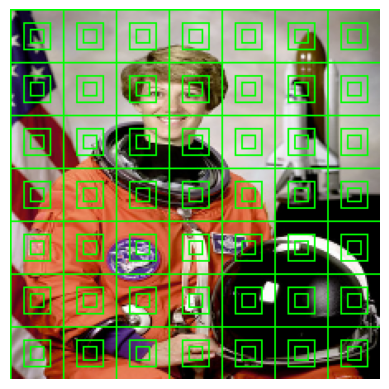

In [77]:
# draw box in original image
image_with_boxes = image.copy()
for (x0, y0, x1, y1) in anchors:
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    cv2.rectangle(image_with_boxes, (x0, y0), (x1, y1), (0, 255, 0), 1)

# show image with bounding box
imshow(image_with_boxes, isBGR=False)

- Apply Region Proposal Network

In [78]:
class SimpleRegionProposalNetwork(nn.Module):
    def __init__(self, anchor_generator, rpn_head, nms_thresh=0.4, num_proposals=1000):
        super(SimpleRegionProposalNetwork, self).__init__()
        self.anchor_generator = anchor_generator
        self.rpn_head = rpn_head
        self.nms_thresh = nms_thresh
        self.num_proposals = num_proposals

    def forward(self, feature_map, image_size):
        # 1. Generate anchors
        grid_size = feature_map.shape[-2:]  # (height, width)
        stride = image_size[0] // grid_size[0]  # Calculate stride based on input and feature map sizes
        anchors = self.anchor_generator.generate_anchors(grid_size, stride).to(feature_map.device)

        # 2. Get objectness and bbox deltas from RPN head
        objectness, bbox_deltas = self.rpn_head(feature_map)

        # 3. Decode bbox deltas to proposals
        proposals = self.apply_deltas_to_anchors(anchors, bbox_deltas)

        # 4. Filter proposals using NMS
        batch_size = feature_map.shape[0]
        final_proposals = []
        for i in range(batch_size):
            # Select proposals above an objectness threshold (e.g., 0.5) for simplicity
            keep = objectness[i, :, 0] > 0.5
            scores = objectness[i, keep, 0]
            proposals_for_image = proposals[i][keep]

            # Apply Non-Maximum Suppression (NMS)
            keep_indices = self.nms(proposals_for_image, scores, self.nms_thresh)
            proposals_after_nms = proposals_for_image[keep_indices]

            # Limit to the top `num_proposals` proposals
            final_proposals.append(proposals_after_nms[:self.num_proposals])

        return final_proposals

    def apply_deltas_to_anchors(self, anchors, deltas):
        anchors = anchors.unsqueeze(0)  # Add batch dimension
        widths = anchors[:, :, 2] - anchors[:, :, 0]
        heights = anchors[:, :, 3] - anchors[:, :, 1]
        ctr_x = anchors[:, :, 0] + 0.5 * widths
        ctr_y = anchors[:, :, 1] + 0.5 * heights

        dx = deltas[..., 0]
        dy = deltas[..., 1]
        dw = deltas[..., 2]
        dh = deltas[..., 3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w = torch.exp(dw) * widths
        pred_h = torch.exp(dh) * heights

        pred_boxes = torch.zeros_like(deltas)
        pred_boxes[..., 0] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[..., 1] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[..., 2] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[..., 3] = pred_ctr_y + 0.5 * pred_h

        return pred_boxes

    def nms(self, boxes, scores, iou_threshold):
        keep = []
        indices = scores.argsort(descending=True)
        while indices.numel() > 0:
            current = indices[0]
            keep.append(current)
            if indices.numel() == 1:
                break
            ious = self.iou(boxes[current].unsqueeze(0), boxes[indices[1:]])
            try :
                indices = indices[1:][ious.squeeze(1) <= iou_threshold]
            except Exception as e:
                break
        return torch.tensor(keep, dtype=torch.long, device=boxes.device)

    def iou(self, box1, box2):
        inter_xmin = torch.max(box1[:, None, 0], box2[:, 0])
        inter_ymin = torch.max(box1[:, None, 1], box2[:, 1])
        inter_xmax = torch.min(box1[:, None, 2], box2[:, 2])
        inter_ymax = torch.min(box1[:, None, 3], box2[:, 3])

        inter_area = (inter_xmax - inter_xmin).clamp(min=0) * (inter_ymax - inter_ymin).clamp(min=0)
        box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
        box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

        union_area = box1_area[:, None] + box2_area - inter_area
        return inter_area / union_area


In [81]:
# Example usage
# Initialize with simple anchor generator and RPN head
anchor_generator = SimpleAnchorGenerator(sizes=[16, 32, 64, 128, 256], aspect_ratios=[0.5, 1.0, 2.0])
rpn_head = SimpleRPNHead(in_channels=512, num_anchors=9)
rpn = SimpleRegionProposalNetwork(anchor_generator, rpn_head)

# Generate proposals for a feature map Resnet-34
proposals = rpn(feature_map, (W, H))
print([p.shape for p in proposals])  # Print the shape of proposals for each image in the batch

RuntimeError: The size of tensor a (441) must match the size of tensor b (735) at non-singleton dimension 1

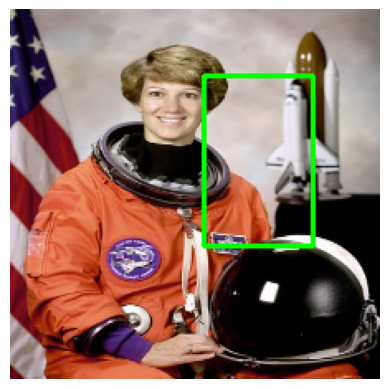

In [58]:
# Extract proposals from output tensor
proposals_np = proposals[0].detach().cpu().numpy()

# # Calculate scaling factors
# scale_x = original_image.shape[1] / 224
# scale_y = original_image.shape[0] / 224

# # Scale proposals back to original image dimensions
# rescaled_proposals = []
# for (x_min, y_min, x_max, y_max) in proposals:
#     rescaled_proposals.append((
#         int(x_min * scale_x), int(y_min * scale_y),
#         int(x_max * scale_x), int(y_max * scale_y)
#     ))

# Draw bounding boxes on the original image
image_with_boxes = image.copy()
for (x_min, y_min, x_max, y_max) in proposals_np[:100]:  # Display the top 100 proposals
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the image with bounding boxes
imshow(image_with_boxes, isBGR=False)

- Decoding the Predicted Boxes

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


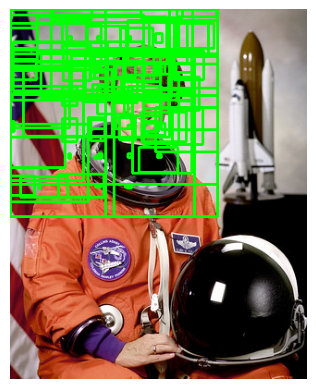

In [65]:
from torchvision.models.detection.rpn import RPNHead, RegionProposalNetwork
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.image_list import ImageList

# Load an image and preprocess
image_path = 'astronaut.jpg'
original_image = cv2.imread(image_path)
input_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Preprocess image to fit ResNet input size
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Ensure it fits the ResNet input requirements
    transforms.ToTensor(),
])

input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension

# Load ResNet-34 backbone from torch.hub
backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])  # Remove the FC layer

# Get the feature map by passing the image through the backbone
with torch.no_grad():
    feature_map = backbone(input_tensor)  # Shape: [1, C, H, W]

# Wrap the feature map in an OrderedDict as expected by torchvision's RPN
feature_maps = {'0' : feature_map}

# Define anchor generator with different scales and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((4, 8, 16, 32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define RPN head (classification and bounding box regression heads)
rpn_head = RPNHead(in_channels=feature_map.shape[1], num_anchors=anchor_generator.num_anchors_per_location()[0])

# Define Region Proposal Network
rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=rpn_head,
    fg_iou_thresh=0.8,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n={'training': 2000, 'testing': 1000},
    post_nms_top_n={'training': 2000, 'testing': 300},
    nms_thresh=0.7
)

image_list = ImageList(input_tensor, [(W, H)])

# Forward pass through RPN to get proposals
rpn.eval()  # Set RPN to evaluation mode
with torch.no_grad():
    proposals, _ = rpn(image_list, feature_maps)

# Extract proposals from output tensor
proposals = proposals[0].cpu().numpy()

# Draw bounding boxes on the original image
image_with_boxes = original_image.copy()
for (x_min, y_min, x_max, y_max) in proposals[:100]:  # Display the top 100 proposals
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the image with bounding boxes
imshow(image_with_boxes)


_____
<br>
<br>
<br>
<br>

## Source
- https://www.linkedin.com/pulse/basic-building-blocks-k-means-clustering-algorithms-hemant-thapa-jnide/